# Micro-narrative analysis of _The Lord of the Rings_

In [1]:
import glob
import os.path

import pandas as pd

docs = []
for file in glob.glob("input/*.txt"):
    with open(file) as f:
        text = f.read()
        sections = text.split("\n")
        for section in sections:
            section = section.strip()
            if section:
                docs.append(section)

In [2]:
from narrativegraphs import CooccurrenceGraph

if os.path.exists("lotr.db"):
    model = CooccurrenceGraph.load("lotr.db")
else:
    model = CooccurrenceGraph(
        sqlite_db_path="lotr.db",
        on_existing_db="overwrite",
        n_cpu=1
    ).fit(docs)

In [3]:
model.cooccurrences_

,id,entity_one,entity_one_frequency,entity_two,entity_two_frequency,frequency,doc_frequency,spread,adjusted_tf_idf,pmi,entity_one_id,entity_two_id
0,1,Three Rings,36,elven,340,1,1,0.000108,0.0,1.834190,1,2
1,2,Three Rings,36,The sky,1494,1,1,0.000108,0.0,1.191318,1,3
2,3,elven,340,The sky,1494,2,2,0.000216,3080.0,0.517172,2,3
3,4,Dwarf,771,Hal,974,4,4,0.000433,5544.0,0.648418,4,5
4,5,Darkness,8600,Darkness,8600,44,41,0.004437,9460.0,-0.303573,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...
284326,284327,Rose,93,little Elanor,18,1,1,0.000108,0.0,2.698216,7886,16133
284327,284328,his lap,100,Rose,93,1,1,0.000108,0.0,1.953488,7812,7886
284328,284329,his chair,245,little Elanor,18,1,1,0.000108,0.0,2.277533,2167,16133
284329,284330,his chair,245,his lap,100,1,1,0.000108,0.0,1.532805,2167,7812


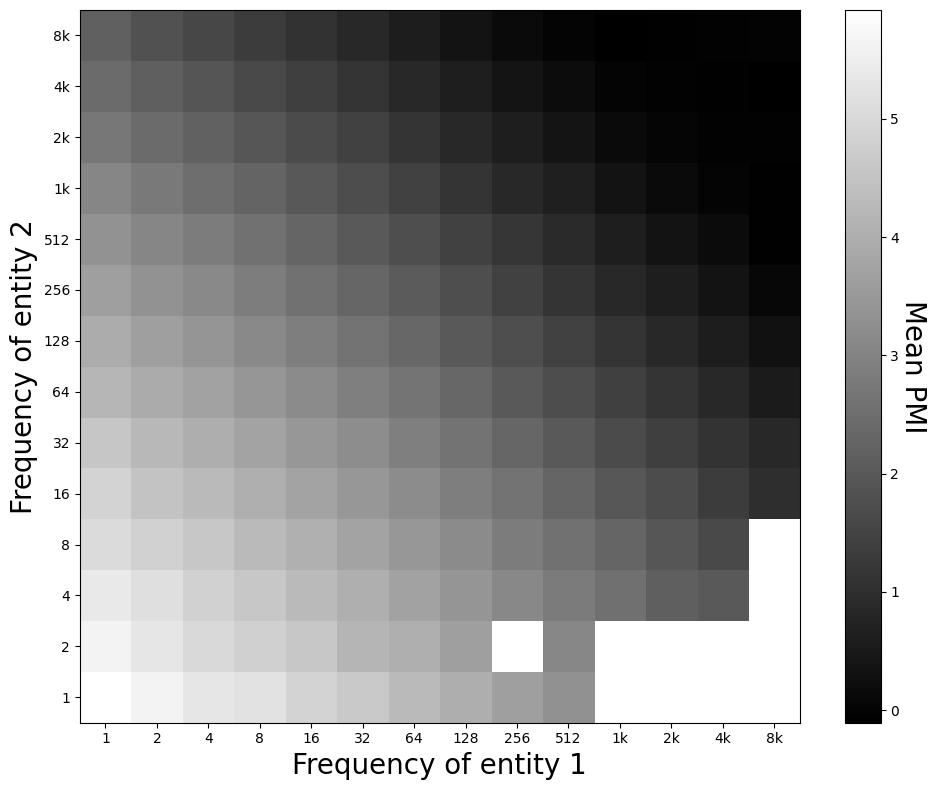

In [4]:
from sharedutils import visualize_pmi_by_frequency

visualize_pmi_by_frequency(model.cooccurrences_)

In [21]:
from narrativegraphs import GraphFilter

graph_filter = GraphFilter(
    minimum_edge_frequency=1,
    minimum_node_frequency=3,
    minimum_edge_doc_frequency=1,
    maximum_node_frequency=100
)

In [22]:
comms = model.graph.find_communities(
    graph_filter=graph_filter,
    min_weight=2,
    community_detection_method_args=dict(k=3)
)
comm_contexts = []

for comm in sorted(comms, key=lambda c: c.score, reverse=True):
    if len(comm.members) < 2: continue
    print(*[e.label for e in comm.members], sep=", ")
    contexts = model.tuplets.get_contexts_by_entity_ids(comm.member_ids)
    contexts.sort(key=lambda c: c.doc_id)
    for context in contexts:
        context.print_with_ansi_highlight()
    comm_contexts.append(contexts)
    print()

the flakes, the dying fire, their slackening
ID: 2775, OFFSET: 0
Frodo gazed wearily at the flakes still falling out of the dark to be revealed white for a moment in the light of the dying fire; but for a long time he could see no sign of their slackening. Then suddenly, as sleep was beginning to creep over him again, he was aware that the wind had indeed fallen, and the flakes were becoming larger and fewer. Very slowly a dim light began to grow. At last the snow stopped altogether.

your little game, tea-time, decent places
ID: 6490, OFFSET: 74
What's your little game? It isn't time yet. It can't be tea-time even, leastways not in decent places where there is tea-time.'

your bonfire, And I, my pyre
ID: 7485, OFFSET: 96
Go back to your bonfire! And I? I will go now to my pyre. To my pyre! No tomb for Denethor and Faramir. No tomb!

`Steady, Steady, at least more feeling, the open passage
ID: 2963, OFFSET: 0
`Steady! Steady! ' cried Gandalf as Merry and Pippin pushed forward, glad to 

In [30]:
sorted_contexts = sorted(comm_contexts, key=lambda ctx: ctx[0].doc_id)
x = []
y = []
for i, contexts in enumerate(sorted_contexts):
    for context in contexts:
        x.append(context.doc_id)
        y.append(i)

<Axes: >

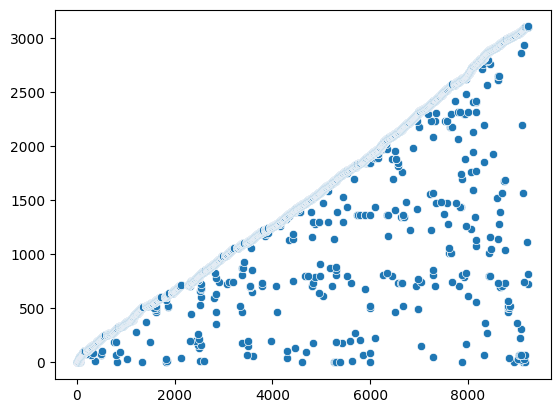

In [32]:
import seaborn as sns

sns.scatterplot(x=x, y=y)

In [7]:
comms = model.graph.find_communities(
    graph_filter=graph_filter,
    community_detection_method="louvain",
    min_weight=2,
    community_detection_method_args=dict(resolution=5)
)
for comm in sorted(comms, key=lambda c: c.score, reverse=True):
    if len(comm.members) < 2: continue
    members = [e.label for e in comm.members]
    print(*members, sep=", ")
    contexts = model.tuplets.get_contexts_by_entity_ids(comm.member_ids)
    for context in contexts:
        context.print_with_ansi_highlight()
    print()

Stinker, Slinker
ID: 5970, OFFSET: 378
Sam's guess was that the Sméagol and Gollum halves (or what in his own mind he called Slinker and Stinker) had made a truce and a temporary alliance: neither wanted the Enemy to get the Ring; both wished to keep Frodo from capture, and under their eye, as long as possible  at any rate as long as Stinker still had a chance of laying hands on his 'Precious'. Whether there really was another way into Mordor Sam doubted.
ID: 6580, OFFSET: 0
'Yes, Slinker and Stinker, as I've said before,' said Sam. 'But the nearer they get to the Enemy's land the more like Stinker Slinker will get. Mark my words: if ever we get to the pass, he won't let us really take the precious thing over the border without making some kind of trouble.'

Forlong, Lossarnach
ID: 7000, OFFSET: 0
'Forlong! Forlong!' Pippin heard men calling. 'What do they say?'
ID: 7001, OFFSET: 0
'Forlong has come,' Bergil answered; 'old Forlong the Fat, the Lord of Lossarnach. That is where my gran

In [7]:
# create server to be viewed in own browser which blocks execution of other cells
model.serve_visualizer()

INFO:     Started server process [16390]
INFO:     Waiting for application startup.
INFO:root:Database engine provided to state before startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8001 (Press CTRL+C to quit)


INFO:     127.0.0.1:58515 - "GET / HTTP/1.1" 304 Not Modified
INFO:     127.0.0.1:58515 - "GET /static/js/main.a230418a.js HTTP/1.1" 304 Not Modified
INFO:     127.0.0.1:58516 - "GET /static/css/main.8226d438.css HTTP/1.1" 200 OK
INFO:     127.0.0.1:58518 - "GET /graph/bounds/cooccurrence HTTP/1.1" 200 OK
INFO:     127.0.0.1:58518 - "OPTIONS /graph HTTP/1.1" 200 OK
INFO:     127.0.0.1:58518 - "POST /graph HTTP/1.1" 200 OK
INFO:     127.0.0.1:58531 - "OPTIONS /entities/search/gibbets HTTP/1.1" 200 OK
INFO:     127.0.0.1:58531 - "GET /entities/search/gibbets HTTP/1.1" 200 OK
INFO:     127.0.0.1:58531 - "POST /graph HTTP/1.1" 200 OK
INFO:     127.0.0.1:58539 - "GET /entities/10225 HTTP/1.1" 200 OK
INFO:     127.0.0.1:58539 - "GET /entities/10225/docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:58547 - "GET /cooccurrences/161826 HTTP/1.1" 200 OK
INFO:     127.0.0.1:58547 - "GET /cooccurrences/161826/docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:58564 - "GET /entities/10233 HTTP/1.1" 200 OK
INFO:     

INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [16390]
INFO:root:Server stopped by user
